## In this notebook: Fig 5E, Fig S9

In [37]:

import mne


import pandas as pd
import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("article.mplstyle")
import numpy as np
import scipy
import seaborn as sns


from scipy.io import loadmat, savemat
from scipy.stats import pearsonr, spearmanr, sem, ttest_rel, ttest_1samp
from scipy.stats.mstats import winsorize
from pingouin import rm_anova


from statannotations.Annotator import Annotator
from itertools import combinations
from collections import Counter

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*
from ERP_utils import *


import pickle
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Set up

In [ ]:

train = 'motor'

mapchange_dir = '../analysis_error/mapchange_csv_corrected_since_bymap_till/'
pred_dir = f'../analysis_error/mtrf_error_surprise/rTRF_predictions_{train}'
sv_dir ='../analysis_error/mtrf_error_surprise/sv'
good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()

#plot params for supplementary figs
xtick_fontsize = 15
axis_fontsize = 20


## Fig S9C-D: Correlate with support vectors

In [39]:

periods =[ 'pre', 'post']
subjects_to_process =  good_error_subjects

pearson_o_stat = []
pearson_o_p = []
pearson_shuf_stat = []
pearson_shuf_p = []

corr_sv_df = pd.DataFrame()

for subject in subjects_to_process:
    for period in periods:

        sub_df = {
            'subject': subject,
            'period': period
        }
    # print(subject)
        pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
        pred_stim = pred_data['predicted_stim'][0]
        # print(pred_stim.shape)

        #load support vectors
        sv_onsets = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['onsets'][0] 
        sv_firsts = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['firsts'][0] 

        if sv_firsts.shape[0]>pred_stim.shape[0]:
            # sv_firsts = sv_firsts[:pred_stim.shape[0]]
            sv_onsets = sv_onsets[:pred_stim.shape[0]]

        
        #correlation with support vectors
        try:
            #correlation with onsets
            res_o = pearsonr(pred_stim, sv_onsets) 
            sub_df['pearson_onsets_stat'] = res_o.statistic
            sub_df['pearson_onsets_p'] = res_o.pvalue
            # pearson_o_stat.append(res_o.statistic)
            # pearson_o_p.append(res_o.pvalue)

            #correlation with shuffled onsets
            res_o_shuf = pearsonr(pred_stim, np.random.permutation(sv_onsets))
            sub_df['pearson_shuffled_stat'] = res_o_shuf.statistic
            sub_df['pearson_shuffled_p'] = res_o_shuf.pvalue
            # pearson_shuf_stat.append(res_o_shuf.statistic)
            # pearson_shuf_p.append(res_o_shuf.pvalue)

            corr_sv_df = pd.concat([corr_sv_df, pd.DataFrame([sub_df])], ignore_index=True)
        except ValueError: 
            print('ValueError at subject', subject)
            continue #some value errors at subjects where the last note was cut off


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

post_pearson_onsets_stat vs. post_pearson_shuffled_stat: Custom statistical test, P_val:6.714e-04
pre_pearson_onsets_stat vs. pre_pearson_shuffled_stat: Custom statistical test, P_val:1.289e-03


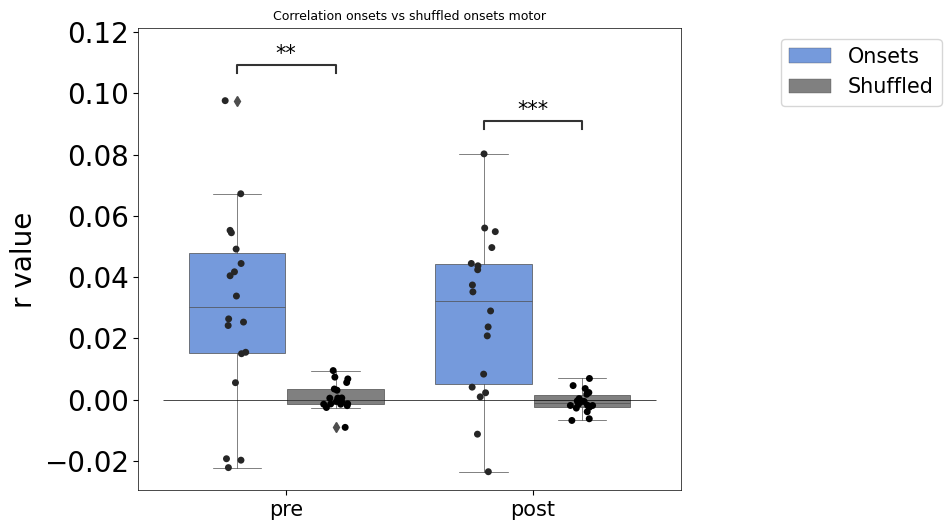

In [40]:
plt.figure(figsize = (7,6))
colours = {
    'pearson_onsets_stat': 'cornflowerblue',
    'pearson_shuffled_stat': 'grey'
}

corr_sv_df_sns = pd.melt(corr_sv_df, id_vars = ['subject', 'period'], value_vars = ['pearson_onsets_stat', 'pearson_shuffled_stat'], var_name = 'correlation_type', value_name = 'correlation_value')
ax = sns.boxplot(corr_sv_df_sns, x = 'period', y = 'correlation_value', hue = 'correlation_type', palette = colours)
sns.stripplot(corr_sv_df_sns, x = 'period', y = 'correlation_value', hue = 'correlation_type', color = 'black', dodge = True)



#stat annotations
pairs = [(('pre','pearson_onsets_stat'), ('pre','pearson_shuffled_stat')),
         (('post','pearson_onsets_stat'), ('post','pearson_shuffled_stat'))]

#manually calculate p values
_, p_pre = wilcoxon(corr_sv_df.query('period == "pre"')['pearson_onsets_stat'], corr_sv_df.query('period == "pre"')['pearson_shuffled_stat'])
_, p_post = wilcoxon(corr_sv_df.query('period == "post"')['pearson_onsets_stat'], corr_sv_df.query('period == "post"')['pearson_shuffled_stat'])

annotator = Annotator(ax, pairs, data=corr_sv_df_sns, x='period', y='correlation_value', hue = 'correlation_type')
annotator.configure(text_format='star', loc='inside', fontsize=15)
annotator.set_pvalues([p_pre, p_post])

annotator.annotate()


ax = plt.gca()
# ax.set_xlabel('')
# ax.set_ylabel('correlation coefficient', fontsize = axis_fontsize)
ax.set_xticklabels(['pre', 'post'], fontsize = xtick_fontsize)
plt.title(f'Correlation onsets vs shuffled onsets {train}')
plt.ylabel('r value', fontsize = axis_fontsize)
plt.xlabel('')
plt.yticks(fontsize = axis_fontsize)
plt.hlines(0, -0.5, 1.5, color = 'black')
plt.legend(title = '', fontsize = xtick_fontsize,  bbox_to_anchor=(1.5, 1))

# Rename legend entries manually
label_map = {
    'pearson_onsets_stat': 'Onsets',
    'pearson_shuffled_stat': 'Shuffled'
}
handles, labels = ax.get_legend_handles_labels()
new_labels = [label_map.get(l, l) for l in labels]
ax.legend(handles[:2], new_labels[:2], title='', fontsize=xtick_fontsize, bbox_to_anchor=(1.5, 1))

# plt.savefig(f'../figs/corr_onsets_shuffled_{train}.svg')

## Fig 5E: mTRF reconstruction for firsts vs others

In [41]:
# periods = ['post']
periods = ['pre', 'post']
pred_amp_df = []
# subjects_to_process = ['01','04','05','06','07','08','09','10','11','12']
subjects_to_process = good_error_subjects

for subject in subjects_to_process:
    for period in periods:

        sub_data = {
            'subject': subject,
            'period': period
        }
        
        #look at predictions on post using pre models
        # pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_datapost_modelpre.mat'))
        
        #look at predictions with time-matched models
        pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
        pred_stim = pred_data['predicted_stim'][0]

        #find times for keystrokes
        fo_df = pd.read_csv(os.path.join(mapchange_dir,f'mapchange_keystrokes_{period}_{subject}.csv'))
        others_times = fo_df[fo_df['type']=='other']['time']
        firsts_times = fo_df[fo_df['type']=='first']['time']

        #compare reconstructed amplitudes at keystrokes
        amp_others = pred_stim[others_times].mean()
        amp_firsts = pred_stim[firsts_times].mean()

        sub_data['others'] = amp_others
        sub_data['firsts'] = amp_firsts
    
        pred_amp_df.append(sub_data)    

pred_amp_df = pd.DataFrame(pred_amp_df)



In [42]:
# show stats
pred_amp_df['diff'] = pred_amp_df['firsts'] - pred_amp_df['others']
pred_amp_df_melt = pred_amp_df.melt(id_vars=['subject', 'period'], 
                 value_vars = ['others', 'firsts'], 
                 value_name = 'pred_amp',
                 var_name='type')


anova_res = rm_anova(data = pred_amp_df_melt, dv = 'pred_amp', within = ['period', 'type'], subject = 'subject')
anova_res

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,period,0.000006,1,17,0.000006,0.360098,0.556367,0.556367,0.002312,1.0
1,type,0.000010,1,17,0.000010,6.531205,0.020472,0.020472,0.003788,1.0
2,period * type,0.000002,1,17,0.000002,0.699064,0.414696,0.414696,0.000590,1.0


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

post_others vs. post_firsts: Custom statistical test, P_val:7.690e-03
pre_others vs. pre_firsts: Custom statistical test, P_val:6.095e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Wilcoxon test (paired samples), P_val:2.928e-01 Stat=2.650e+02


/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


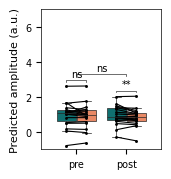

In [43]:
fig = plt.figure(figsize = (1.2,1.4))
ax = fig.add_axes([0,0,1,1])

fo_colours = {'firsts': 'teal', 'others': 'coral'}
flierprops = dict(marker='o', markersize=1, linestyle='none', markerfacecolor='gray', alpha=0.6)

ax = sns.boxplot(data = pred_amp_df_melt, x = 'period', y = 'pred_amp', hue = 'type', 
                 hue_order=['firsts', 'others'], palette=fo_colours, flierprops=flierprops)

#plot individual subject lines
for period in periods:
    if period == 'pre':
        x_pos =  [-0.2, 0.2]
    elif period == 'post':
        x_pos = [0.8, 1.2]

    for subject in subjects_to_process:

        amp_toplot = pred_amp_df_melt.query(f'subject == "{subject}" and period == "{period}"')
        amp_firsts = amp_toplot.query(f'type == "firsts"')['pred_amp'].values[0]
        amp_others = amp_toplot.query(f'type == "others"')['pred_amp'].values[0]
    
        ax.plot(x_pos, [amp_firsts, amp_others], color = 'black', marker = 'o', markersize = 1, linewidth = 0.8)


_, p_pre = wilcoxon(pred_amp_df_melt.query('period == "pre" & type == "firsts"')['pred_amp'], pred_amp_df_melt.query('period == "pre" & type == "others"')['pred_amp'])
_, p_post = wilcoxon(pred_amp_df_melt.query('period == "post" & type == "firsts"')['pred_amp'], pred_amp_df_melt.query('period == "post" & type == "others"')['pred_amp'])


#firsts vs others within the period
pairs = [(('pre', 'firsts'), ('pre', 'others')),(('post', 'firsts'), ('post', 'others'))]
annotator = Annotator(ax, pairs, data=pred_amp_df_melt, x='period', y='pred_amp', hue='type')
annotator.set_pvalues([p_pre, p_post])
annotator.configure(fontsize = mpl.rcParams['xtick.labelsize'],
                    line_width = mpl.rcParams['lines.linewidth'])
annotator.annotate()

#Pre vs post main effect
pairs = [("pre", "post")]
annot = Annotator(ax, pairs, data=pred_amp_df_melt, x='period', y='pred_amp')
annot.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2, 
                fontsize = mpl.rcParams['xtick.labelsize'],
                    line_width = mpl.rcParams['lines.linewidth'])
annot.apply_and_annotate()

ax.legend_.remove()

# plt.legend(title = '', bbox_to_anchor=(1.5, 1))
plt.ylabel('Predicted amplitude')
plt.ylabel('Predicted amplitude (a.u.)')
plt.yticks([0, 0.02, 0.04, 0.06])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 1e2)}'))  # Convert to µV as integer

# plt.xticks(fontsize = xtick_fontsize)
# plt.title(f'Predicted amplitude using reverse TRF trained on {train}')
plt.ylim(-0.01, 0.07)
plt.xlabel('')
plt.savefig(f'./figures/pred_prepost_{train}.svg')

## Fig S9A-B: Reconstructed stim window

In [44]:
mapchange_dir_bymap = '../analysis_error/mapchange_csv_corrected_since_bymap_till/'
periods = ['pre', 'post']
pred_amp_df_window = []
# subjects_to_process = ['01','04','05','06','07','08','09','10','11','12']
subjects_to_process = ['01','04','05','06','07','08','09','10','11','12', '13', '14', '15', '16', '18', '19', '20']

window = 20
map_to_plot = 'norm'

for subject in subjects_to_process:
    for period in periods:

        sub_data = {
            'subject': subject,
            'period': period
        }

        pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
        pred_stim = pred_data['predicted_stim'][0]
        
        fo_df = pd.read_csv(os.path.join(mapchange_dir_bymap,f'mapchange_keystrokes_{period}_{subject}.csv'))

        #find times for keystrokes
        if map_to_plot == 'all_maps':
            others_times = fo_df[fo_df['type']=='other']['time']
            firsts_times = fo_df[fo_df['type']=='first']['time']

        else:
            others_times = fo_df[(fo_df['type']=='other') & (fo_df['prev_map'] == map_to_plot)]['time']
            firsts_times = fo_df[(fo_df['type']=='first') & (fo_df['prev_map'] == map_to_plot)]['time']

        # Get slices around each time point 
        window_others = np.array([pred_stim[max(0, t-window) : min(len(pred_stim), t+window+1)] for t in others_times])
        window_firsts = np.array([pred_stim[max(0, t-window) : min(len(pred_stim), t+window+1)] for t in firsts_times])

        #average to get mean window shape
        sub_data['others'] = np.expand_dims(np.mean(window_others, axis = 0), axis = 0)
        sub_data['firsts'] = np.expand_dims(np.mean(window_firsts, axis = 0), axis = 0)


    
        pred_amp_df_window.append(sub_data)    

pred_amp_df_window = pd.DataFrame(pred_amp_df_window)

(0.0, 0.03)

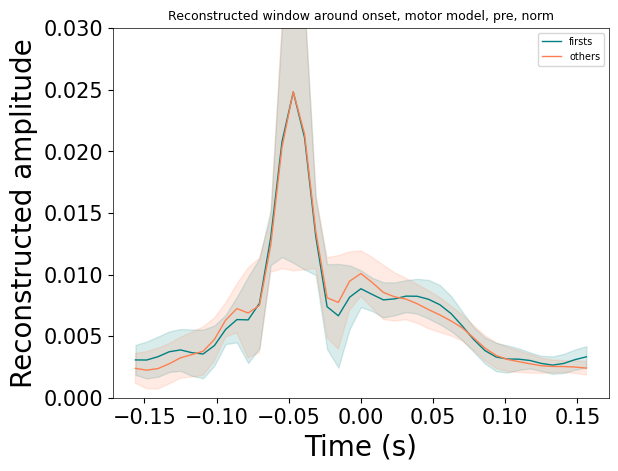

In [45]:

period = 'pre'
mean_firsts, sem_firsts = find_mean_sem_evs(pred_amp_df_window.query(f'period == "{period}"'), 0, col_to_ave='firsts')
mean_others, sem_others = find_mean_sem_evs(pred_amp_df_window.query(f'period == "{period}"'), 0, col_to_ave='others')

erp_times = create_erp_times(-0.15625, 0.15625, 128)
plot_mean_sem(erp_times, mean_firsts, sem_firsts, color = 'teal', label = 'firsts')
plot_mean_sem(erp_times, mean_others, sem_others, color = 'coral', label = 'others')
plt.legend()
plt.title(f'Reconstructed window around onset, {train} model, {period}, {map_to_plot}')
plt.ylabel('Reconstructed amplitude', fontsize = axis_fontsize)
plt.xlabel('Time (s)', fontsize = axis_fontsize)
plt.yticks(fontsize = xtick_fontsize)
plt.xticks(fontsize = xtick_fontsize)
plt.ylim(0, 0.03)
